In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load Service 2 results
service2_df = pd.read_csv('../../../results/Service2.csv')

In [14]:
# --- Basic Checks ---
print("Null values:\n", service2_df.isnull().sum())
print("\nData types:\n", service2_df.dtypes)

Null values:
 timestamp           0
cpu_allocated       0
memory_allocated    0
cpu_usage_pct       0
memory_usage_pct    0
latency_ms          0
dtype: int64

Data types:
 timestamp            object
cpu_allocated       float64
memory_allocated    float64
cpu_usage_pct       float64
memory_usage_pct    float64
latency_ms          float64
dtype: object


In [15]:
# --- Descriptive Statistics ---
print("\nDescriptive stats:\n", service2_df.describe())


Descriptive stats:
        cpu_allocated  memory_allocated  cpu_usage_pct  memory_usage_pct  \
count   10000.000000      10000.000000   10000.000000      10000.000000   
mean        0.550000       1152.000000      50.000000         10.946165   
std         0.259877        517.383443      40.878341         19.120931   
min         0.100000        256.000000       0.250000          0.000000   
25%         0.327500        703.997500       4.740000          0.030000   
50%         0.550000       1152.000000      50.000000          0.670000   
75%         0.772500       1600.002500      95.260000         11.922500   
max         1.000000       2048.000000      99.750000         73.110000   

         latency_ms  
count  10000.000000  
mean     426.917444  
std      360.015810  
min       55.670000  
25%      130.660000  
50%      179.980000  
75%      811.785000  
max     1308.870000  


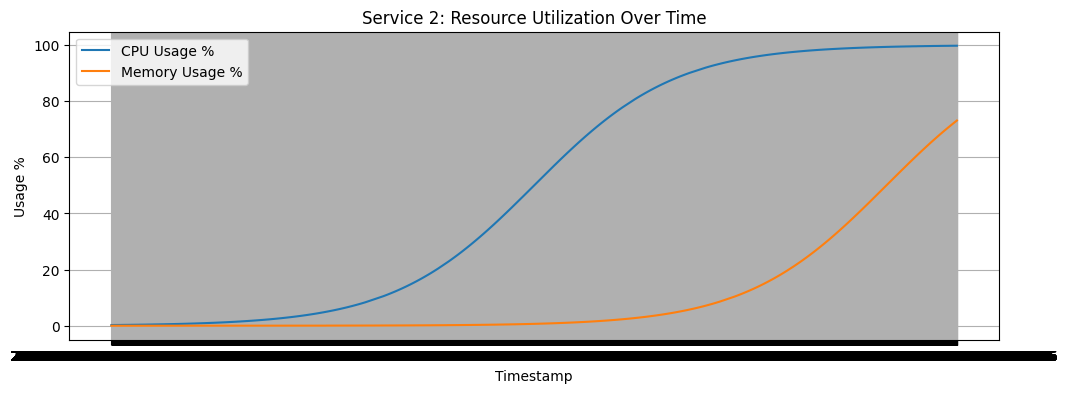

In [16]:
# --- Resource Utilization over Time ---
plt.figure(figsize=(12, 4))
plt.plot(service2_df['timestamp'], service2_df['cpu_usage_pct'], label='CPU Usage %')
plt.plot(service2_df['timestamp'], service2_df['memory_usage_pct'], label='Memory Usage %')
plt.legend()
plt.title("Service 2: Resource Utilization Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Usage %")
plt.grid(True)
plt.show()

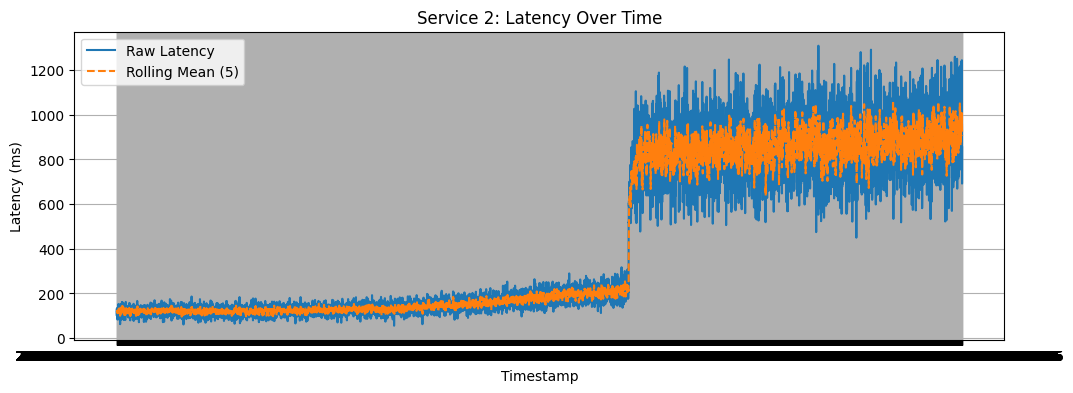

In [17]:
# --- Latency Trend with Rolling Average ---
plt.figure(figsize=(12, 4))
plt.plot(service2_df['timestamp'], service2_df['latency_ms'], label='Raw Latency')
plt.plot(service2_df['timestamp'], service2_df['latency_ms'].rolling(window=5).mean(), label='Rolling Mean (5)', linestyle='--')
plt.legend()
plt.title("Service 2: Latency Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Latency (ms)")
plt.grid(True)
plt.show()

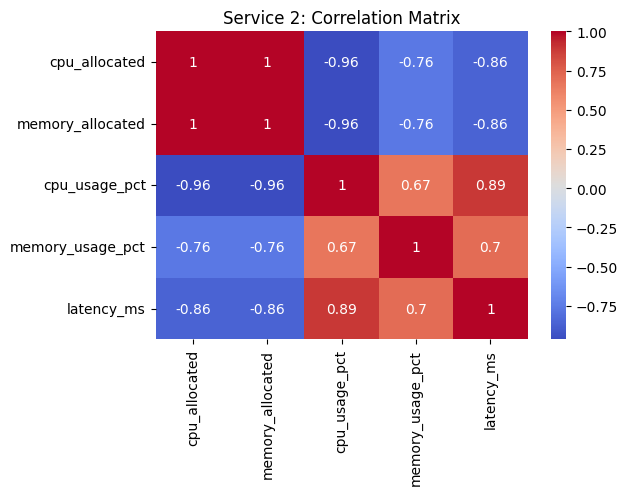

In [18]:
# --- Correlation Analysis ---
plt.figure(figsize=(6, 4))
sns.heatmap(service2_df[['cpu_allocated',  'memory_allocated','cpu_usage_pct', 'memory_usage_pct', 'latency_ms']].corr(), annot=True, cmap='coolwarm')
plt.title("Service 2: Correlation Matrix")
plt.show()

In [19]:
# --- Outlier Detection for Resource Usage and Latency ---

# Z-score Method for outlier detection
z_scores_cpu = zscore(service2_df['cpu_usage_pct'])
z_scores_memory = zscore(service2_df['memory_usage_pct'])
z_scores_latency = zscore(service2_df['latency_ms'])

# Define a threshold for detecting outliers (e.g., 3 standard deviations)
threshold = 3
outliers_cpu = service2_df[abs(z_scores_cpu) > threshold]
outliers_memory = service2_df[abs(z_scores_memory) > threshold]
outliers_latency = service2_df[abs(z_scores_latency) > threshold]

In [20]:
# Print outliers
print("\nOutliers based on Z-score:")
print(f"CPU Usage Outliers: {outliers_cpu.shape[0]}")
print(f"Memory Usage Outliers: {outliers_memory.shape[0]}")
print(f"Latency Outliers: {outliers_latency.shape[0]}")


Outliers based on Z-score:
CPU Usage Outliers: 0
Memory Usage Outliers: 194
Latency Outliers: 0


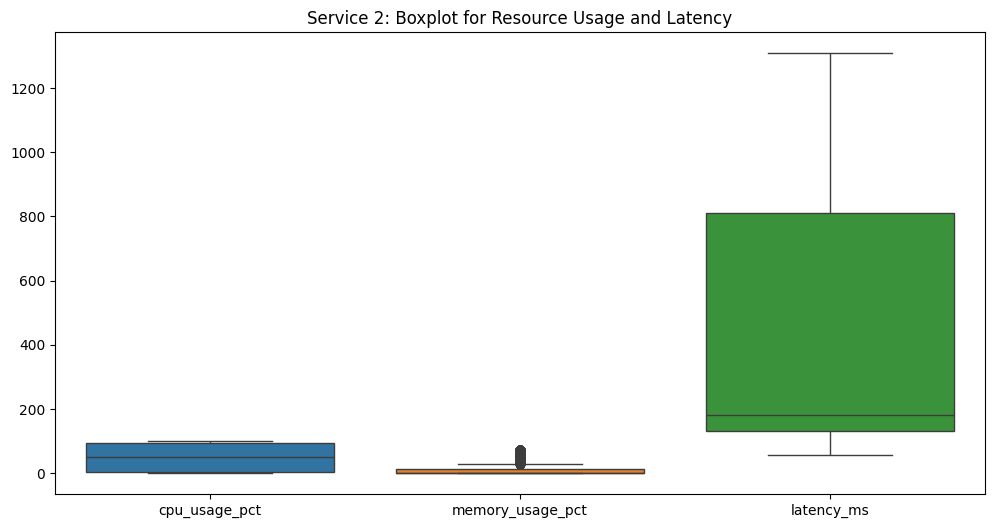

In [21]:
# Boxplot for visual outlier detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=service2_df[['cpu_usage_pct', 'memory_usage_pct', 'latency_ms']])
plt.title("Service 2: Boxplot for Resource Usage and Latency")
plt.show()

In [22]:
# Function to detect spikes using rolling mean and rolling std
def detect_spikes(df, window_size, threshold=3):
    df['rolling_mean'] = df['latency_ms'].rolling(window=window_size).mean()
    df['rolling_std'] = df['latency_ms'].rolling(window=window_size).std()
    
    outliers_spikes = df[abs(df['latency_ms'] - df['rolling_mean']) > threshold * df['rolling_std']]
    return len(outliers_spikes)

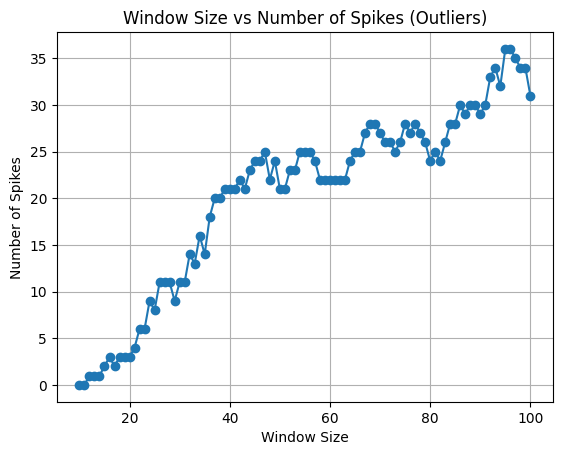

In [23]:
# List to store window sizes and number of spikes detected
window_sizes = list(range(10, 101))
spikes_count = []

# Loop over window sizes and detect spikes
for window_size in window_sizes:
    num_spikes = detect_spikes(service2_df, window_size)
    spikes_count.append(num_spikes)

# Plot the relationship between window size and number of spikes
plt.plot(window_sizes, spikes_count, marker='o')
plt.title('Window Size vs Number of Spikes (Outliers)')
plt.xlabel('Window Size')
plt.ylabel('Number of Spikes')
plt.grid(True)
plt.show()

In [24]:
# Step 1: Calculate latency difference between consecutive timestamps
service2_df['latency_diff'] = service2_df['latency_ms'].diff()

# Step 2: Define a spike (latency difference greater than the mean latency)
threshold = service2_df['latency_ms'].mean()  # Define threshold as mean latency
service2_df['is_spike'] = service2_df['latency_diff'] > threshold

# Step 3: Select spike windows (rows where spikes occurred)
spike_windows = service2_df[service2_df['is_spike']]

# Step 4: Analyze CPU and memory usage around the spike times
for i, row in spike_windows.iterrows():
    print(f"Spike at {row['timestamp']} | CPU: {row['cpu_usage_pct']}% | Mem: {row['memory_usage_pct']}%")

Spike at 2025-05-09 11:55:37.453505 | CPU: 83.36% | Mem: 3.26%
Spike at 2025-05-09 12:53:37.453505 | CPU: 84.3% | Mem: 3.49%
Spike at 2025-05-09 12:59:37.453505 | CPU: 84.4% | Mem: 3.52%
Spike at 2025-05-09 13:37:37.453505 | CPU: 84.99% | Mem: 3.67%
Spike at 2025-05-09 14:53:37.453505 | CPU: 86.11% | Mem: 4.01%
Spike at 2025-05-09 16:21:37.453505 | CPU: 87.33% | Mem: 4.44%
Spike at 2025-05-09 18:06:37.453505 | CPU: 88.66% | Mem: 5.0%
Spike at 2025-05-09 20:41:37.453505 | CPU: 90.4% | Mem: 5.97%
Spike at 2025-05-10 00:54:37.453505 | CPU: 92.73% | Mem: 7.92%
Spike at 2025-05-10 02:54:37.453505 | CPU: 93.64% | Mem: 9.03%
Spike at 2025-05-10 04:13:37.453505 | CPU: 94.19% | Mem: 9.84%
Spike at 2025-05-10 08:08:37.453505 | CPU: 95.55% | Mem: 12.64%
Spike at 2025-05-10 08:13:37.453505 | CPU: 95.58% | Mem: 12.71%
Spike at 2025-05-10 08:45:37.453505 | CPU: 95.74% | Mem: 13.14%
Spike at 2025-05-10 08:49:37.453505 | CPU: 95.76% | Mem: 13.19%
Spike at 2025-05-10 08:56:37.453505 | CPU: 95.79% | Mem